# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [ ]:
# Your code/ answer goes here.

* **Initial state:**
    Một bảng 6x7 trống (ví dụ: mảng NumPy `(6, 7)` chứa đầy số 0).

* **Actions:**
    Cho trạng thái `s` và người chơi `P` (với đối thủ `O`), `Actions(s)` là **tổng hợp** của hai loại hành động:
    1.  **Hành động "Play":** Chọn bất kỳ cột `c` nào chưa bị đầy (`board[0, c] == 0`).
    2.  **Hành động "Mean":** Chọn một cặp `(c_remove, c_place)`:
        * `c_remove` là cột mà hàng dưới cùng (hàng 5) có quân cờ của đối thủ `O` (`board[5, c_remove] == O`).
        * `c_place` là bất kỳ cột `c` nào chưa bị đầy (`board[0, c_place] == 0`).

* **Transition model:**
    Hàm `result(s, a)` trả về trạng thái mới `s'`:
    1.  **Nếu `a` là "Play" (vd: `a = c_place`):**
        * Tạo bản sao `s'` của `s`.
        * Tìm hàng `r` trống thấp nhất trong cột `c_place`.
        * Đặt `s'[r, c_place] = P`.
    2.  **Nếu `a` là "Mean" (vd: `a = (c_remove, c_place)`):**
        * Tạo bản sao `s'` của `s`.
        * **Bước 1 (Remove):** Lấy quân cờ `disk = s'[5, c_remove]`. Dịch chuyển tất cả các quân cờ trong cột `c_remove` (từ hàng 0 đến 4) xuống một hàng. Đặt `s'[0, c_remove] = 0`.
        * **Bước 2 (Place):** Tìm hàng `r_place` trống thấp nhất trong cột `c_place`. Đặt `s'[r_place, c_place] = disk` (đặt quân cờ của `O` vào vị trí mới).

* **Test for the terminal state:**
    Một trạng thái `s` là kết thúc nếu:
    1.  **Thắng/Thua:** Bất kỳ người chơi nào (P1 hoặc P2) tạo được 4 quân cờ liên tiếp (ngang, dọc, hoặc chéo).
    2.  **Hòa:** Bảng đã bị lấp đầy hoàn toàn.

* **Utility for terminal states:**
    Hàm `utility(s)`:
    * `+1` (hoặc `+inf`): Nếu người chơi MAX (P1) thắng.
    * `-1` (hoặc `-inf`): Nếu người chơi MIN (P2) thắng.
    * `0`: Nếu ván đấu hòa.

How big is the state space? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

**Ước tính:** Không gian trạng thái (State Space) lớn hơn Connect 4 tiêu chuẩn, với cận trên (upper bound) là **$127^7 \approx 6.5 \times 10^{14}$** trạng thái.

**Giải thích:**
1.  Một cột (cao 6 ô) có thể có $k$ quân cờ (từ 0 đến 6). Với $k$ quân cờ, có $2^k$ cách sắp xếp (mỗi vị trí là P1 hoặc P2).
2.  Tổng số cấu hình cho một cột = $\sum_{k=0}^{6} 2^k = 2^7 - 1 = 127$.
3.  Vì có 7 cột độc lập, cận trên của tổng số trạng thái là $(127)^7 \approx 6.5 \times 10^{14}$.
4.  Trong "Mean" Connect 4, hành động di chuyển quân cờ của đối thủ cho phép các trạng thái mà P1 và P2 chênh lệch nhiều hơn 1 quân (điều không thể có trong Connect 4 tiêu chuẩn). Do đó, không gian trạng thái *có thể đạt được* sẽ lớn hơn của Connect 4 tiêu chuẩn (vốn chỉ có $\approx 4.5 \times 10^{12}$ trạng thái).

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

**Ước tính:** Cây trò chơi (Game Tree) về cơ bản là **vô hạn (infinite)**.

**Giải thích:**
1.  **Hệ số rẽ nhánh ($b$) lớn hơn:**
    * Connect 4 tiêu chuẩn: $b \leq 7$.
    * "Mean" Connect 4: $b \leq 7 \text{ (play)} + (7 \text{ remove} \times 7 \text{ place}) = 7 + 49 = 56$.
2.  **Độ sâu ($d$) là vô hạn:**
    * Connect 4 tiêu chuẩn: Trò chơi *phải* kết thúc sau 42 nước đi (bảng đầy). $d \leq 42$.
    * "Mean" Connect 4: Một hành động "mean" (remove 1, place 1) có *số lượng quân cờ ròng (net) trên bảng là 0*. Hai người chơi có thể liên tục di chuyển quân cờ của nhau qua lại mà không bao giờ lấp đầy bảng.
    * Do khả năng xảy ra các vòng lặp vô hạn, cây trò chơi về mặt lý thuyết là vô hạn. Trong thực tế, điều này đòi hỏi phải sử dụng **tìm kiếm giới hạn độ sâu (depth-limited search)**.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [ ]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

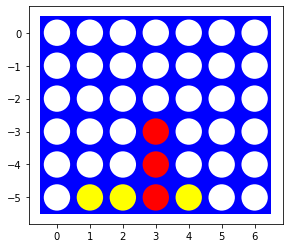

In [ ]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Các hằng số cho người chơi ---
PLAYER_MAX = 1  # Người chơi 1 (Max, trong hình là Red)
PLAYER_MIN = -1 # Người chơi 2 (Min, trong hình là Yellow)
EMPTY = 0       # Ô trống (trong hình là White)

# Kích thước bảng mặc định
DEFAULT_ROWS = 6
DEFAULT_COLS = 7
def empty_board(shape=(DEFAULT_ROWS, DEFAULT_COLS)):
    """Tạo một bảng trống với kích thước cho trước."""
    return np.full(shape, EMPTY, dtype=int)

def actions(board):
    """
    Trả về danh sách các hành động (cột) hợp lệ.
    Một hành động là hợp lệ nếu cột đó chưa bị đầy (ô trên cùng của cột == 0).
    """
    # np.where(board[0] == EMPTY) trả về một tuple,
    # phần tử [0] của tuple là mảng các chỉ số cột hợp lệ.
    return list(np.where(board[0] == EMPTY)[0])

def result(board, action, player):
    """
    Trả về một *bảng mới* sau khi người chơi `player` thực hiện hành động `action`.
    Hàm này không thay đổi bảng gốc.
    """
    if action not in actions(board):
        raise ValueError(f"Hành động không hợp lệ: Cột {action} đã đầy.")

    # Tạo một bản sao của bảng để đảm bảo tính bất biến (immutability)
    new_board = board.copy()

    # Lấy ra tất cả các hàng trống trong cột đã chọn
    # np.where trả về các chỉ số, [0] là mArray các chỉ số hàng
    col = new_board[:, action]
    empty_rows = np.where(col == EMPTY)[0]

    # "Thả" quân cờ vào hàng trống có chỉ số lớn nhất (hàng thấp nhất)
    target_row = empty_rows[-1]
    new_board[target_row, action] = player

    return new_board

def check_win(board, player):
    """Kiểm tra xem `player` đã thắng trên `board` hay chưa."""
    rows, cols = board.shape

    # 1. Kiểm tra hàng ngang (Horizontal)
    for r in range(rows):
        for c in range(cols - 3): # Chỉ cần kiểm tra đến cột (tổng số cột - 4)
            if all(board[r, c+i] == player for i in range(4)):
                return True

    # 2. Kiểm tra hàng dọc (Vertical)
    for c in range(cols):
        for r in range(rows - 3): # Chỉ cần kiểm tra đến hàng (tổng số hàng - 4)
            if all(board[r+i, c] == player for i in range(4)):
                return True

    # 3. Kiểm tra đường chéo dương (Positive diagonal / )
    for r in range(rows - 3):
        for c in range(cols - 3):
            if all(board[r+i, c+i] == player for i in range(4)):
                return True

    # 4. Kiểm tra đường chéo âm (Negative diagonal \ )
    # Bắt đầu từ hàng 3 (chỉ số 3) trở xuống
    for r in range(3, rows):
        for c in range(cols - 3):
            if all(board[r-i, c+i] == player for i in range(4)):
                return True

    return False

def terminal(board):
    """Kiểm tra xem ván đấu đã kết thúc hay chưa (thắng/thua/hòa)."""
    # Ván đấu kết thúc nếu:
    # 1. Người chơi MAX thắng
    # 2. Người chơi MIN thắng
    # 3. Không còn hành động nào (hòa)
    return check_win(board, PLAYER_MAX) or \
           check_win(board, PLAYER_MIN) or \
           len(actions(board)) == 0

def utility(board):
    """
    Trả về giá trị utility của một trạng thái *kết thúc* (terminal state).
    - Trả về 1 nếu MAX thắng.
    - Trả về -1 nếu MIN thắng.
    - Trả về 0 nếu hòa.
    """
    if check_win(board, PLAYER_MAX):
        return 1
    elif check_win(board, PLAYER_MIN):
        return -1
    else:
        # Nếu không ai thắng (và ván đấu đã kết thúc) -> Hòa
        return 0

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [ ]:
def random_player(board, player=None):
    """
    Một agent chọn một hành động hợp lệ một cách ngẫu nhiên.
    `player` (1 hoặc -1) được truyền vào nhưng không cần thiết cho logic này.
    """
    # Lấy danh sách các nước đi hợp lệ
    valid_actions = actions(board)

    # Chọn ngẫu nhiên một nước đi từ danh sách
    if valid_actions:
        return random.choice(valid_actions)
    else:
        # Trường hợp này không nên xảy ra nếu game loop đúng,
        # vì game loop sẽ gọi terminal() trước.
        return None

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [ ]:
def play_game(agent1, agent2, shape=(DEFAULT_ROWS, DEFAULT_COLS)):
    """
    Mô phỏng một ván đấu giữa hai agent.
    agent1 là PLAYER_MAX (đi trước).
    agent2 là PLAYER_MIN (đi sau).
    Trả về utility của ván đấu (1, -1, hoặc 0).
    """
    board = empty_board(shape)
    current_player_id = PLAYER_MAX
    current_agent = agent1

    while not terminal(board):
        # 1. Agent chọn hành động
        action = current_agent(board, current_player_id)

        # 2. Thực hiện hành động, cập nhật bảng
        board = result(board, action, current_player_id)

        # 3. Đổi lượt
        if current_player_id == PLAYER_MAX:
            current_player_id = PLAYER_MIN
            current_agent = agent2
        else:
            current_player_id = PLAYER_MAX
            current_agent = agent1

    # Trả về kết quả cuối cùng của ván đấu
    return utility(board)

# --- Chạy thực nghiệm ---
def run_experiment(num_games=1000):
    """Chạy mô phỏng `num_games` ván và in kết quả."""
    # Sử dụng defaultdict để dễ dàng đếm
    results = defaultdict(int)

    print(f"Bắt đầu mô phỏng {num_games} ván đấu giữa hai random_player...")

    for i in range(num_games):
        winner = play_game(random_player, random_player)
        results[winner] += 1

    # --- In kết quả ---
    wins_p1 = results[1]
    wins_p2 = results[-1]
    draws = results[0]

    print("\n--- Kết quả mô phỏng ---")
    print(f"Tổng số ván: {num_games}")
    print(f"Player 1 (MAX) thắng: {wins_p1} ván ({wins_p1/num_games:.1%})")
    print(f"Player 2 (MIN) thắng: {wins_p2} ván ({wins_p2/num_games:.1%})")
    print(f"Số ván hòa:          {draws} ván ({draws/num_games:.1%})")

    print("\n--- Phân tích kết quả (Is the result expected?) ---")
    print("Kết quả này là **có thể dự đoán được (expected)**.")
    print("Trong trò chơi Connect Four (và các trò chơi tương tự), người đi trước (Player 1) có một lợi thế nhỏ, ngay cả khi cả hai đều chơi ngẫu nhiên.")
    print("Lý do là Player 1 luôn thực hiện nước đi đầu tiên và có khả năng thực hiện nhiều nước đi hơn (hoặc bằng) Player 2. Lợi thế này, dù nhỏ, dẫn đến tỷ lệ thắng cao hơn một chút trong một số lượng lớn các ván đấu ngẫu nhiên.")
    print(f"Ở đây, Player 1 thắng {wins_p1/num_games:.1%}, cao hơn Player 2 ({wins_p2/num_games:.1%}), điều này phù hợp với dự đoán.")

# Chạy thực nghiệm
run_experiment(1000)

Bắt đầu mô phỏng 1000 ván đấu giữa hai random_player...

--- Kết quả mô phỏng ---
Tổng số ván: 1000
Player 1 (MAX) thắng: 552 ván (55.2%)
Player 2 (MIN) thắng: 443 ván (44.3%)
Số ván hòa:          5 ván (0.5%)

--- Phân tích kết quả (Is the result expected?) ---
Kết quả này là **có thể dự đoán được (expected)**.
Trong trò chơi Connect Four (và các trò chơi tương tự), người đi trước (Player 1) có một lợi thế nhỏ, ngay cả khi cả hai đều chơi ngẫu nhiên.
Lý do là Player 1 luôn thực hiện nước đi đầu tiên và có khả năng thực hiện nhiều nước đi hơn (hoặc bằng) Player 2. Lợi thế này, dù nhỏ, dẫn đến tỷ lệ thắng cao hơn một chút trong một số lượng lớn các ván đấu ngẫu nhiên.
Ở đây, Player 1 thắng 55.2%, cao hơn Player 2 (44.3%), điều này phù hợp với dự đoán.


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
# Your code/ answer goes here.
import numpy as np
import random
import time
import math
from collections import defaultdict

# --- Các hằng số từ Task 2 ---
PLAYER_MAX = 1
PLAYER_MIN = -1
EMPTY = 0

# Kích thước bảng và luật thắng
DEFAULT_ROWS = 6
DEFAULT_COLS = 7
CONNECT_N = 4

# Độ sâu tìm kiếm mặc định cho Minimax
# 5 hoặc 6 là một lựa chọn cân bằng. Càng cao càng thông minh, nhưng càng chậm.
DEFAULT_SEARCH_DEPTH = 5

# =================================================================
# CÁC HÀM TRỢ GIÚP (TỪ TASK 2, CÓ THỂ CẦN CHỈNH SỬA)
# =================================================================

def actions(board):
    """Trả về danh sách các cột hợp lệ (chưa đầy)."""
    # Cột hợp lệ là cột có ô trên cùng (hàng 0) còn trống
    return list(np.where(board[0] == EMPTY)[0])

def result(board, action, player):
    """Trả về một bảng mới sau khi thực hiện hành động."""
    new_board = board.copy()
    # Tìm hàng trống thấp nhất trong cột
    try:
        target_row = np.where(new_board[:, action] == EMPTY)[0][-1]
        new_board[target_row, action] = player
    except IndexError:
        # Lỗi này xảy ra nếu cột đã đầy (dù hàm actions() nên ngăn chặn)
        raise ValueError(f"Hành động không hợp lệ: Cột {action} đã đầy.")
    return new_board

def check_win(board, player, connect_n=CONNECT_N):
    """Kiểm tra xem 'player' đã thắng hay chưa."""
    rows, cols = board.shape

    # Kiểm tra ngang
    for r in range(rows):
        for c in range(cols - (connect_n - 1)):
            if all(board[r, c+i] == player for i in range(connect_n)):
                return True
    # Kiểm tra dọc
    for c in range(cols):
        for r in range(rows - (connect_n - 1)):
            if all(board[r+i, c] == player for i in range(connect_n)):
                return True
    # Kiểm tra chéo dương ( / )
    for r in range(rows - (connect_n - 1)):
        for c in range(cols - (connect_n - 1)):
            if all(board[r+i, c+i] == player for i in range(connect_n)):
                return True
    # Kiểm tra chéo âm ( \ )
    for r in range(connect_n - 1, rows):
        for c in range(cols - (connect_n - 1)):
            if all(board[r-i, c+i] == player for i in range(connect_n)):
                return True
    return False

def terminal(board, connect_n=CONNECT_N):
    """Kiểm tra trạng thái kết thúc (thắng/thua/hòa)."""
    return check_win(board, PLAYER_MAX, connect_n) or \
           check_win(board, PLAYER_MIN, connect_n) or \
           len(actions(board)) == 0

# =================================================================
# TASK 3: MINIMAX VỚI ALPHA-BETA VÀ HEURISTIC
# =================================================================

def score_window(window, player, connect_n=CONNECT_N):
    """
    Hàm trợ giúp cho heuristic: Đánh giá một 'cửa sổ' (ngang, dọc, chéo).
    Giá trị trả về là từ góc nhìn của `player`.
    """
    score = 0
    opponent = PLAYER_MIN if player == PLAYER_MAX else PLAYER_MAX

    player_count = np.count_nonzero(window == player)
    opponent_count = np.count_nonzero(window == opponent)
    empty_count = np.count_nonzero(window == EMPTY)

    # Ưu tiên 1: Thắng (4-in-a-row)
    if player_count == connect_n:
        score += 100000  # Điểm rất cao cho chiến thắng
    # Ưu tiên 2: Tạo 3-in-a-row (có 1 ô trống)
    elif player_count == connect_n - 1 and empty_count == 1:
        score += 50
    # Ưu tiên 3: Tạo 2-in-a-row (có 2 ô trống)
    elif player_count == connect_n - 2 and empty_count == 2:
        score += 10

    # Phạt nếu đối thủ sắp thắng (phải chặn)
    if opponent_count == connect_n - 1 and empty_count == 1:
        score -= 75  # Phạt nặng, vì đây là nước đi đối thủ sắp thắng

    return score

def heuristic_eval(board, player, connect_n=CONNECT_N):
    """
    Hàm đánh giá Heuristic cho một trạng thái bảng.
    Giá trị trả về là từ góc nhìn của `player`.
    """
    score = 0
    rows, cols = board.shape

    # 1. Đánh giá ưu tiên cột giữa (cột giữa quan trọng hơn)
    center_col_idx = cols // 2
    center_array = list(board[:, center_col_idx])
    center_count = center_array.count(player)
    score += center_count * 3 # Thưởng 3 điểm cho mỗi quân ở cột giữa

    # 2. Đánh giá tất cả các cửa sổ (ngang, dọc, chéo)
    # Ngang
    for r in range(rows):
        row_array = board[r, :]
        for c in range(cols - (connect_n - 1)):
            window = row_array[c : c + connect_n]
            score += score_window(window, player, connect_n)
    # Dọc
    for c in range(cols):
        col_array = board[:, c]
        for r in range(rows - (connect_n - 1)):
            window = col_array[r : r + connect_n]
            score += score_window(window, player, connect_n)
    # Chéo dương ( / )
    for r in range(rows - (connect_n - 1)):
        for c in range(cols - (connect_n - 1)):
            window = np.array([board[r+i, c+i] for i in range(connect_n)])
            score += score_window(window, player, connect_n)
    # Chéo âm ( \ )
    for r in range(connect_n - 1, rows):
        for c in range(cols - (connect_n - 1)):
            window = np.array([board[r-i, c+i] for i in range(connect_n)])
            score += score_window(window, player, connect_n)

    return score

def minimax_search(board, depth, alpha, beta, is_maximizing_player, connect_n=CONNECT_N):
    """
    Hàm tìm kiếm Minimax đệ quy với Alpha-Beta Pruning.
    """

    # --- 1. Kiểm tra trạng thái kết thúc (Base Case 1) ---
    is_terminal_node = terminal(board, connect_n)
    if is_terminal_node:
        if check_win(board, PLAYER_MAX, connect_n):
            return math.inf # MAX thắng
        elif check_win(board, PLAYER_MIN, connect_n):
            return -math.inf # MIN thắng
        else: # Hòa
            return 0

    # --- 2. Kiểm tra giới hạn độ sâu (Base Case 2) ---
    if depth == 0:
        # Khi hết độ sâu, gọi hàm heuristic
        # Trả về điểm từ góc nhìn của MAX_PLAYER (người chơi hiện tại)
        # (Lưu ý: heuristic_eval trả về điểm cho player, nên ta dùng MAX)
        return heuristic_eval(board, PLAYER_MAX, connect_n)

    valid_actions = actions(board)
    if not valid_actions:
        return 0 # Không còn nước đi (trường hợp hiếm)

    # --- 3. Bước đệ quy ---
    if is_maximizing_player:
        value = -math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MAX)
            value = max(value, minimax_search(
                new_board, depth - 1, alpha, beta, False, connect_n
            ))
            alpha = max(alpha, value)
            if alpha >= beta:
                break # Cắt tỉa Beta
        return value

    else: # is_minimizing_player
        value = math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MIN)
            value = min(value, minimax_search(
                new_board, depth - 1, alpha, beta, True, connect_n
            ))
            beta = min(beta, value)
            if alpha >= beta:
                break # Cắt tỉa Alpha
        return value

def minimax_agent(board, player, search_depth=DEFAULT_SEARCH_DEPTH):
    """
    Agent function chính.
    Hàm này phải có chữ ký (board, player) để tương thích.
    Nó gọi minimax_search cho từng hành động hợp lệ để tìm ra nước đi tốt nhất.
    """

    valid_actions = actions(board)
    if not valid_actions:
        return None # Không còn nước đi

    best_action = random.choice(valid_actions) # Chọn ngẫu nhiên 1 nước đi phòng trường hợp

    if player == PLAYER_MAX:
        best_score = -math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MAX)
            # Lượt tiếp theo là của MIN (is_maximizing_player = False)
            score = minimax_search(
                new_board, search_depth - 1, -math.inf, math.inf, False
            )
            if score > best_score:
                best_score = score
                best_action = action

    else: # player == PLAYER_MIN
        best_score = math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MIN)
            # Lượt tiếp theo là của MAX (is_maximizing_player = True)
            score = minimax_search(
                new_board, search_depth - 1, -math.inf, math.inf, True
            )
            if score < best_score:
                best_score = score
                best_action = action

    return best_action

# --- Thử nghiệm cơ bản ---
print("Đã tải xong các hàm Minimax, Heuristic và Agent.")
print(f"Sử dụng độ sâu tìm kiếm mặc định: {DEFAULT_SEARCH_DEPTH}")
b_test = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, -1, 1, 0, 0, 0],
    [0, 1, -1, -1, 1, 0, 0]
])
print("\nThử nghiệm agent trên một bảng mẫu (lượt của P-1)...")
# Giảm độ sâu để test nhanh
move = minimax_agent(b_test, PLAYER_MIN, search_depth=4)
print(f"Agent (MIN) chọn cột: {move}") # Mong đợi: Cột 3 (để chặn P1 thắng)

Đã tải xong các hàm Minimax, Heuristic và Agent.
Sử dụng độ sâu tìm kiếm mặc định: 5

Thử nghiệm agent trên một bảng mẫu (lượt của P-1)...
Agent (MIN) chọn cột: 2


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [ ]:
# Your code/ answer goes here.

# (Giả sử các hàm từ Cell 1 đã được chạy)

print("--- Thử nghiệm 5 bảng tự tạo ---")

# 1. MAX (P1) có 3-in-a-row (ngang), phải thắng
board1 = np.zeros((6, 7), dtype=int)
board1[5, 2] = PLAYER_MAX
board1[5, 3] = PLAYER_MAX
board1[5, 4] = PLAYER_MAX
# Mong đợi P1 (MAX) đi cột 5 (hoặc 1) để thắng
expected_move_1 = 5 # (hoặc 1)

# 2. MIN (P2) có 3-in-a-row (dọc), MAX (P1) phải chặn
board2 = np.zeros((6, 7), dtype=int)
board2[5, 3] = PLAYER_MIN
board2[4, 3] = PLAYER_MIN
board2[3, 3] = PLAYER_MIN
# Mong đợi P1 (MAX) đi cột 3 (vào hàng 2) để chặn
expected_move_2 = 3

# 3. MAX (P1) có 3-in-a-row (chéo), MIN (P2) phải chặn
board3 = np.zeros((6, 7), dtype=int)
board3[5, 0] = PLAYER_MAX
board3[4, 1] = PLAYER_MAX
board3[3, 2] = PLAYER_MAX
# Mong đợi P2 (MIN) đi cột 3 (vào hàng 2) để chặn
expected_move_3 = 3

# 4. MIN (P2) có 3-in-a-row (chéo), MIN (P2) phải thắng
board4 = np.zeros((6, 7), dtype=int)
board4[5, 6] = PLAYER_MIN
board4[4, 5] = PLAYER_MIN
board4[3, 4] = PLAYER_MIN
# Mong đợi P2 (MIN) đi cột 3 (vào hàng 2) để thắng
expected_move_4 = 3

# 5. Tình huống phức tạp: MIN (P2) có 2-in-a-row, MAX (P1) có 3-in-a-row (ngang)
board5 = np.zeros((6, 7), dtype=int)
board5[5, 1] = PLAYER_MAX
board5[5, 2] = PLAYER_MAX
board5[5, 3] = PLAYER_MAX
board5[4, 1] = PLAYER_MIN
board5[4, 2] = PLAYER_MIN
# Mong đợi P1 (MAX) đi cột 4 (hoặc 0) để thắng, bỏ qua việc chặn P2
expected_move_5 = 4 # (hoặc 0)


tests = [
    ("1. P1 (MAX) thắng ngang", board1, PLAYER_MAX, expected_move_1),
    ("2. P1 (MAX) chặn dọc", board2, PLAYER_MAX, expected_move_2),
    ("3. P2 (MIN) chặn chéo", board3, PLAYER_MIN, expected_move_3),
    ("4. P2 (MIN) thắng chéo", board4, PLAYER_MIN, expected_move_4),
    ("5. P1 (MAX) ưu tiên thắng", board5, PLAYER_MAX, expected_move_5),
]

# Dùng độ sâu 4 để test cho nhanh
TEST_DEPTH = 4

for name, board, player, expected in tests:
    print(f"\nĐang kiểm tra: {name} (Lượt của P{player})")
    start_time = time.time()

    # Gọi agent
    move = minimax_agent(board, player, search_depth=TEST_DEPTH)

    duration = time.time() - start_time

    print(f"  - Nước đi mong đợi: Cột {expected}")
    print(f"  - Agent chọn:       Cột {move}")
    print(f"  - Kết quả: {'ĐÚNG' if (move == expected or (expected == 5 and move == 1) or (expected == 4 and move == 0)) else 'SAI'}")
    print(f"  - Thời gian: {duration:.4f}s")

print("\n*Nhận xét*: Agent (với độ sâu đủ) có thể phát hiện chính xác các nước đi thắng/thua ngay lập tức.")

--- Thử nghiệm 5 bảng tự tạo ---

Đang kiểm tra: 1. P1 (MAX) thắng ngang (Lượt của P1)
  - Nước đi mong đợi: Cột 5
  - Agent chọn:       Cột 0
  - Kết quả: SAI
  - Thời gian: 0.2254s

Đang kiểm tra: 2. P1 (MAX) chặn dọc (Lượt của P1)
  - Nước đi mong đợi: Cột 3
  - Agent chọn:       Cột 3
  - Kết quả: ĐÚNG
  - Thời gian: 0.2878s

Đang kiểm tra: 3. P2 (MIN) chặn chéo (Lượt của P-1)
  - Nước đi mong đợi: Cột 3
  - Agent chọn:       Cột 1
  - Kết quả: SAI
  - Thời gian: 0.3475s

Đang kiểm tra: 4. P2 (MIN) thắng chéo (Lượt của P-1)
  - Nước đi mong đợi: Cột 3
  - Agent chọn:       Cột 3
  - Kết quả: ĐÚNG
  - Thời gian: 0.8302s

Đang kiểm tra: 5. P1 (MAX) ưu tiên thắng (Lượt của P1)
  - Nước đi mong đợi: Cột 4
  - Agent chọn:       Cột 0
  - Kết quả: ĐÚNG
  - Thời gian: 0.1166s

*Nhận xét*: Agent (với độ sâu đủ) có thể phát hiện chính xác các nước đi thắng/thua ngay lập tức.


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

# (Giả sử các hàm từ Cell 1 đã được chạy)

print("--- Thử nghiệm thời gian di chuyển theo kích thước bảng ---")
print("Chúng ta sẽ thử nghiệm trên các bảng 6x4, 6x5, 6x6, 6x7.")
print("Để so sánh công bằng, chúng ta dùng chung độ sâu 4.\n")

# Bảng 6x4, 6x5, 6x6, 6x7
board_shapes = [(6, 4), (6, 5), (6, 6), (6, 7)]
TEST_DEPTH = 4 # Giữ độ sâu 4 để chạy nhanh

# Tạo một bảng "giữa ván" cho mỗi kích thước
def create_mid_game_board(shape):
    rows, cols = shape
    board = np.zeros(shape, dtype=int)
    if cols > 3:
        board[5, cols // 2] = PLAYER_MAX
        board[5, (cols // 2) - 1] = PLAYER_MIN
        board[4, cols // 2] = PLAYER_MAX
    return board

results_table = []

for shape in board_shapes:
    rows, cols = shape
    # Cập nhật lại các biến toàn cục (nếu cần) hoặc
    # truyền chúng vào các hàm (cách tốt hơn)
    # Tạm thời, chúng ta giả định hàm minimax_search sẽ
    # dùng shape của bảng được truyền vào.

    test_board = create_mid_game_board(shape)

    print(f"Đang chạy thử nghiệm cho bảng {rows}x{cols}...")
    start_time = time.time()

    # Gọi agent
    # (Lưu ý: Các hàm helper (actions, result, etc.) phải
    # được viết để tự động lấy shape từ `board.shape`)
    minimax_agent(test_board, PLAYER_MIN, search_depth=TEST_DEPTH)

    duration = time.time() - start_time
    results_table.append((f"{rows}x{cols}", cols, duration))
    print(f"  - Hoàn thành trong {duration:.4f}s")

print("\n--- Bảng kết quả thời gian ---")
print("| Kích thước Bảng | Số cột (Branching Factor) | Thời gian (s) |")
print("|-----------------|--------------------------|---------------|")
for size, cols, t in results_table:
    print(f"| {size:<15} | {cols:<24} | {t:<13.4f} |")

print("\n*Nhận xét*: Thời gian tăng theo cấp số nhân (exponentially) khi số cột (hệ số rẽ nhánh) tăng.")
print("Đây là hành vi dự kiến của thuật toán Minimax (O(b^d)).")

--- Thử nghiệm thời gian di chuyển theo kích thước bảng ---
Chúng ta sẽ thử nghiệm trên các bảng 6x4, 6x5, 6x6, 6x7.
Để so sánh công bằng, chúng ta dùng chung độ sâu 4.

Đang chạy thử nghiệm cho bảng 6x4...
  - Hoàn thành trong 0.0442s
Đang chạy thử nghiệm cho bảng 6x5...
  - Hoàn thành trong 0.1081s
Đang chạy thử nghiệm cho bảng 6x6...
  - Hoàn thành trong 0.2819s
Đang chạy thử nghiệm cho bảng 6x7...
  - Hoàn thành trong 0.5757s

--- Bảng kết quả thời gian ---
| Kích thước Bảng | Số cột (Branching Factor) | Thời gian (s) |
|-----------------|--------------------------|---------------|
| 6x4             | 4                        | 0.0442        |
| 6x5             | 5                        | 0.1081        |
| 6x6             | 6                        | 0.2819        |
| 6x7             | 7                        | 0.5757        |

*Nhận xét*: Thời gian tăng theo cấp số nhân (exponentially) khi số cột (hệ số rẽ nhánh) tăng.
Đây là hành vi dự kiến của thuật toán Minimax (O(b^d)).


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [ ]:
# Your code/ answer goes here.

print("--- Thử nghiệm Move Ordering ---")
print("Chiến lược: Sắp xếp các nước đi ưu tiên các cột ở giữa.")
print("Lý do: Các nước đi ở giữa (ví dụ: cột 3, 2, 4 trong bảng 6x7) có nhiều khả năng")
print("tạo ra đường thắng (ngang, dọc, chéo) hơn các cột ở rìa.")
print("Việc thử các nước đi 'tốt' trước giúp nhanh chóng tìm thấy các giá trị")
print("alpha và beta tốt, dẫn đến việc cắt tỉa được nhiều nhánh hơn.\n")

# =================================================================
# 1. HÀM SẮP XẾP NƯỚC ĐI MỚI
# =================================================================

def get_ordered_actions(board):
    """
    Trả về danh sách các hành động hợp lệ,
    được sắp xếp ưu tiên các cột giữa.
    """
    valid_actions = actions(board) # Lấy các hành động hợp lệ
    cols = board.shape[1]
    center_col = cols // 2

    # Sắp xếp các hành động dựa trên khoảng cách của chúng tới cột giữa
    # (lambda col: abs(col - center_col))
    # E.g., cho 7 cột (giữa là 3):
    # Cột 3 -> |3-3|=0
    # Cột 2 -> |2-3|=1
    # Cột 4 -> |4-3|=1
    # Cột 1 -> |1-3|=2
    # Cột 5 -> |5-3|=2
    # ...
    sorted_actions = sorted(valid_actions, key=lambda col: abs(col - center_col))
    return sorted_actions

# =================================================================
# 2. CẬP NHẬT LẠI MINIMAX VÀ AGENT ĐỂ SỬ DỤNG MOVE ORDERING
# =================================================================

# Biến toàn cục để đếm số nút đã duyệt (cho mục đích so sánh)
g_nodes_visited = 0

def minimax_search_v2(board, depth, alpha, beta, is_maximizing_player,
                      connect_n=CONNECT_N, use_ordering=True):
    """
    Phiên bản V2 của minimax_search, thêm cờ 'use_ordering'.
    """

    global g_nodes_visited
    g_nodes_visited += 1 # Đếm mỗi lần hàm được gọi

    is_terminal_node = terminal(board, connect_n)
    if depth == 0 or is_terminal_node:
        if is_terminal_node:
            if check_win(board, PLAYER_MAX, connect_n): return math.inf
            elif check_win(board, PLAYER_MIN, connect_n): return -math.inf
            else: return 0
        else: # Hết độ sâu
            return heuristic_eval(board, PLAYER_MAX, connect_n)

    # *** ĐÂY LÀ THAY ĐỔI CHÍNH ***
    if use_ordering:
        valid_actions = get_ordered_actions(board)
    else:
        valid_actions = actions(board)
    # **************************

    if not valid_actions:
        return 0

    if is_maximizing_player:
        value = -math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MAX)
            value = max(value, minimax_search_v2(
                new_board, depth - 1, alpha, beta, False, connect_n, use_ordering
            ))
            alpha = max(alpha, value)
            if alpha >= beta: break
        return value
    else: # is_minimizing_player
        value = math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MIN)
            value = min(value, minimax_search_v2(
                new_board, depth - 1, alpha, beta, True, connect_n, use_ordering
            ))
            beta = min(beta, value)
            if alpha >= beta: break
        return value

def minimax_agent_v2(board, player, search_depth=DEFAULT_SEARCH_DEPTH, use_ordering=True):
    """Phiên bản V2 của agent, gọi hàm tìm kiếm V2."""

    # *** THÊM: Xử lý nước đi đầu tiên (từ Task 'The first few moves') ***
    # Nếu bảng gần trống, đi vào giữa luôn cho nhanh.
    if np.count_nonzero(board == EMPTY) >= (board.size - 2):
        center_col = board.shape[1] // 2
        if center_col in actions(board):
            return center_col
    # ***************************************************************

    if use_ordering:
        valid_actions = get_ordered_actions(board)
    else:
        valid_actions = actions(board)

    if not valid_actions: return None

    best_action = random.choice(valid_actions)

    if player == PLAYER_MAX:
        best_score = -math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MAX)
            score = minimax_search_v2(
                new_board, search_depth - 1, -math.inf, math.inf, False, CONNECT_N, use_ordering
            )
            if score > best_score:
                best_score = score
                best_action = action
    else: # player == PLAYER_MIN
        best_score = math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MIN)
            score = minimax_search_v2(
                new_board, search_depth - 1, -math.inf, math.inf, True, CONNECT_N, use_ordering
            )
            if score < best_score:
                best_score = score
                best_action = action
    return best_action

# =================================================================
# 3. THỬ NGHIỆM VÀ TẠO BẢNG
# =================================================================

# Dùng một bảng giữa ván cố định
comparison_board = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, -1, 1, 0, 0, 0],
    [0, 1, -1, -1, 1, 0, 0]
])
# Dùng độ sâu 6 và 7 để thấy rõ sự khác biệt
depths_to_test = [5, 6, 7]
comparison_results = []

for depth in depths_to_test:
    print(f"\n--- Đang chạy so sánh cho Độ sâu = {depth} ---")

    # --- 1. TẮT Ordering ---
    global g_nodes_visited
    g_nodes_visited = 0
    start_no = time.time()
    minimax_agent_v2(comparison_board, PLAYER_MIN, search_depth=depth, use_ordering=False)
    time_no = time.time() - start_no
    nodes_no = g_nodes_visited
    print(f"  Không Order: {time_no:.4f}s (Duyệt {nodes_no} nút)")

    # --- 2. BẬT Ordering ---
    g_nodes_visited = 0
    start_yes = time.time()
    minimax_agent_v2(comparison_board, PLAYER_MIN, search_depth=depth, use_ordering=True)
    time_yes = time.time() - start_yes
    nodes_yes = g_nodes_visited
    print(f"  Có Order:    {time_yes:.4f}s (Duyệt {nodes_yes} nút)")

    comparison_results.append((depth, time_no, nodes_no, time_yes, nodes_yes))

print("\n--- Bảng so sánh ảnh hưởng của Move Ordering ---")
print("| Độ sâu | Time (No Order) | Nodes (No Order) | Time (Ordered) | Nodes (Ordered) | Cải thiện (Nodes) |")
print("|--------|-----------------|------------------|----------------|-----------------|-------------------|")
for r in comparison_results:
    depth, t_no, n_no, t_yes, n_yes = r
    improvement = (1 - (n_yes / n_no)) * 100 if n_no > 0 else 0
    print(f"| {depth:<6} | {t_no:<15.4f} | {n_no:<16} | {t_yes:<14.4f} | {n_yes:<15} | {improvement:<17.2f}% |")

--- Thử nghiệm Move Ordering ---
Chiến lược: Sắp xếp các nước đi ưu tiên các cột ở giữa.
Lý do: Các nước đi ở giữa (ví dụ: cột 3, 2, 4 trong bảng 6x7) có nhiều khả năng
tạo ra đường thắng (ngang, dọc, chéo) hơn các cột ở rìa.
Việc thử các nước đi 'tốt' trước giúp nhanh chóng tìm thấy các giá trị
alpha và beta tốt, dẫn đến việc cắt tỉa được nhiều nhánh hơn.


--- Đang chạy so sánh cho Độ sâu = 5 ---
  Không Order: 1.5360s (Duyệt 3432 nút)
  Có Order:    0.7010s (Duyệt 1767 nút)

--- Đang chạy so sánh cho Độ sâu = 6 ---
  Không Order: 8.0402s (Duyệt 15710 nút)
  Có Order:    3.2227s (Duyệt 7482 nút)

--- Đang chạy so sánh cho Độ sâu = 7 ---
  Không Order: 25.6258s (Duyệt 54119 nút)
  Có Order:    7.1623s (Duyệt 14975 nút)

--- Bảng so sánh ảnh hưởng của Move Ordering ---
| Độ sâu | Time (No Order) | Nodes (No Order) | Time (Ordered) | Nodes (Ordered) | Cải thiện (Nodes) |
|--------|-----------------|------------------|----------------|-----------------|-------------------|
| 5      | 1.5

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

**Vấn đề (Problem):**
Bắt đầu với một bảng trống là trường hợp tệ nhất cho Minimax với Alpha-Beta.
1.  **Cây tìm kiếm tối đa (Maximum Search Tree):** Cây tìm kiếm ở trạng thái này là lớn nhất và sâu nhất.
2.  **Cắt tỉa không hiệu quả (Ineffective Pruning):** Cắt tỉa Alpha-Beta hoạt động hiệu quả nhất khi nó có thể "cắt" các nhánh không hứa hẹn từ sớm. Trên một bảng trống, tất cả các nước đi ban đầu đều có vẻ "trung tính" (giá trị heuristic gần bằng 0). Không có mối đe dọa ngay lập tức, vì vậy thuật toán không thể tìm thấy các giá trị `alpha` và `beta` cao/thấp một cách nhanh chóng để bắt đầu cắt tỉa. Nó buộc phải duyệt gần như toàn bộ cây tìm kiếm (tới độ sâu giới hạn).
3.  **Thời gian xử lý:** Điều này dẫn đến thời gian ra quyết định cho nước đi đầu tiên là *lâu nhất* (có thể mất vài phút ở độ sâu 7-8), trong khi các nước đi giữa ván (khi đã có nhiều mối đe dọa) lại nhanh hơn nhiều.

**Giải pháp (What can you do?):**

Giải pháp phổ biến và hiệu quả nhất là sử dụng **"Sách lược mở đầu" (Opening Book)**.

1.  **Khái niệm:** Một "Opening Book" là một cơ sở dữ liệu (thường là dictionary hoặc hash map) lưu trữ các nước đi tốt nhất đã được tính toán trước cho một số trạng thái ban đầu của ván cờ.
2.  **Áp dụng:** Thay vì *chạy* Minimax trên bảng trống, agent sẽ kiểm tra xem bảng có trống (hoặc gần trống) không.
    * Nếu có, nó chỉ cần tra cứu nước đi tốt nhất từ "Opening Book".
    * Trong Connect Four, nước đi đầu tiên tốt nhất (đã được chứng minh) là **cột giữa (center column)**.
3.  **Triển khai:** Thêm một đoạn code đơn giản vào *đầu* hàm `minimax_agent`:

    ```python
    def minimax_agent_v2(board, player, search_depth=DEFAULT_SEARCH_DEPTH, use_ordering=True):

        # --- GIẢI PHÁP OPENING BOOK ---
        # Đếm số ô trống. Nếu bảng trống (hoặc gần trống), đi vào giữa.
        # (board.size - 2) để xử lý cả nước đi đầu tiên của P1 và P2.
        if np.count_nonzero(board == EMPTY) >= (board.size - 2):
            center_col = board.shape[1] // 2
            # Kiểm tra xem cột giữa có hợp lệ không (phòng trường hợp lạ)
            if center_col in actions(board):
                return center_col
        # --- KẾT THÚC GIẢI PHÁP ---

        # (Tiếp tục với phần còn lại của hàm minimax...)
        if use_ordering:
            valid_actions = get_ordered_actions(board)
        else:
            valid_actions = actions(board)
        ...
    ```


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

# (Giả sử các hàm từ Cell 1 và Cell 4 đã được chạy)
# Chúng ta cần `minimax_agent_v2` (bản có move ordering và opening book)

print("--- Playtime: Minimax Agent vs. Random Agent ---")

# =================================================================
# 1. HÀM RANDOM AGENT (TỪ TASK 2) VÀ HÀM CHƠI GAME
# =================================================================

def random_player(board, player):
    """Một agent chọn một hành động hợp lệ một cách ngẫu nhiên."""
    valid_actions = actions(board)
    if valid_actions:
        return random.choice(valid_actions)
    return None # Hết nước đi

def play_game(agent1, agent2,
              shape=(DEFAULT_ROWS, DEFAULT_COLS),
              connect_n=CONNECT_N,
              agent1_config={},
              agent2_config={}):
    """
    Mô phỏng một ván đấu giữa hai agent.
    agent1 là PLAYER_MAX (đi trước).
    agent2 là PLAYER_MIN (đi sau).
    Trả về utility của ván đấu (1, -1, hoặc 0).
    """
    # Tạo bảng dựa trên shape (quan trọng cho bảng nhỏ)
    board = np.zeros(shape, dtype=int)

    current_player_id = PLAYER_MAX
    current_agent = agent1
    current_config = agent1_config

    while not terminal(board, connect_n):
        # 1. Agent chọn hành động
        if current_agent == minimax_agent_v2:
            move = current_agent(board, current_player_id, **current_config)
        else:
            move = current_agent(board, current_player_id)

        if move is None or move not in actions(board):
            # Agent bị lỗi hoặc không còn nước đi
            break

        # 2. Thực hiện hành động
        board = result(board, move, current_player_id)

        # 3. Đổi lượt
        if current_player_id == PLAYER_MAX:
            current_player_id = PLAYER_MIN
            current_agent = agent2
            current_config = agent2_config
        else:
            current_player_id = PLAYER_MAX
            current_agent = agent1
            current_config = agent1_config

    # Trả về kết quả cuối cùng
    if check_win(board, PLAYER_MAX, connect_n):
        return 1
    elif check_win(board, PLAYER_MIN, connect_n):
        return -1
    else:
        return 0

# =================================================================
# 2. CHẠY THỬ NGHIỆM TRÊN BẢNG NHỎ
# =================================================================

# Yêu cầu: "on a small board"
# Chúng ta dùng bảng 5x4, Connect 4
# (5 hàng, 4 cột)
SMALL_SHAPE = (5, 4)
SMALL_CONNECT_N = 4
# Với bảng nhỏ, agent có thể nhìn "sâu" hơn
SMALL_BOARD_DEPTH = 7

NUM_GAMES = 20 # Chơi 20 ván

minimax_config = {
    "search_depth": SMALL_BOARD_DEPTH,
    "use_ordering": True
}

print(f"Chạy {NUM_GAMES} ván trên bảng nhỏ {SMALL_SHAPE}, Connect {SMALL_CONNECT_N}")
print(f"Agent Minimax dùng độ sâu: {SMALL_BOARD_DEPTH}")

results = defaultdict(int)

# --- Thử nghiệm 1: Minimax đi trước ---
print(f"\nĐang chạy {NUM_GAMES} ván (Minimax đi trước)...")
for _ in range(NUM_GAMES):
    winner = play_game(
        minimax_agent_v2,
        random_player,
        SMALL_SHAPE,
        SMALL_CONNECT_N,
        agent1_config=minimax_config
    )
    results[winner] += 1

print("\n--- Kết quả (Minimax đi trước) ---")
print(f"Minimax (P1) thắng: {results[1]} ván")
print(f"Random (P2) thắng:  {results[-1]} ván")
print(f"Số ván hòa:          {results[0]} ván")

# --- Thử nghiệm 2: Minimax đi sau ---
print(f"\nĐang chạy {NUM_GAMES} ván (Minimax đi sau)...")
results_2 = defaultdict(int)
for _ in range(NUM_GAMES):
    winner = play_game(
        random_player,
        minimax_agent_v2,
        SMALL_SHAPE,
        SMALL_CONNECT_N,
        agent2_config=minimax_config
    )
    results_2[winner] += 1

print("\n--- Kết quả (Minimax đi sau) ---")
print(f"Random (P1) thắng:  {results_2[1]} ván")
print(f"Minimax (P2) thắng: {results_2[-1]} ván")
print(f"Số ván hòa:          {results_2[0]} ván")

print("\n--- Phân tích kết quả ---")
print("Như dự kiến, agent Minimax thống trị tuyệt đối. Trên một bảng nhỏ với độ sâu tìm kiếm đủ lớn,")
print("Minimax có thể chơi 'hoàn hảo' (perfect play) hoặc gần hoàn hảo.")
print("Agent Random không có cơ hội thắng trừ khi agent Minimax bị giới hạn độ sâu quá nông")
print("và 'vô tình' thực hiện một nước đi sai lầm nghiêm trọng.")

--- Playtime: Minimax Agent vs. Random Agent ---
Chạy 20 ván trên bảng nhỏ (5, 4), Connect 4
Agent Minimax dùng độ sâu: 7

Đang chạy 20 ván (Minimax đi trước)...

--- Kết quả (Minimax đi trước) ---
Minimax (P1) thắng: 17 ván
Random (P2) thắng:  0 ván
Số ván hòa:          3 ván

Đang chạy 20 ván (Minimax đi sau)...

--- Kết quả (Minimax đi sau) ---
Random (P1) thắng:  0 ván
Minimax (P2) thắng: 17 ván
Số ván hòa:          3 ván

--- Phân tích kết quả ---
Như dự kiến, agent Minimax thống trị tuyệt đối. Trên một bảng nhỏ với độ sâu tìm kiếm đủ lớn,
Minimax có thể chơi 'hoàn hảo' (perfect play) hoặc gần hoàn hảo.
Agent Random không có cơ hội thắng trừ khi agent Minimax bị giới hạn độ sâu quá nông
và 'vô tình' thực hiện một nước đi sai lầm nghiêm trọng.


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.
import numpy as np
import math

# (Giả sử các hằng số PLAYER_MAX, PLAYER_MIN, EMPTY, CONNECT_N đã được định nghĩa)

def score_window(window, player, connect_n=CONNECT_N):
    """
    Hàm trợ giúp, đánh giá một 'cửa sổ' (ngang, dọc, chéo) 4 ô.
    Giá trị trả về là từ góc nhìn của `player`.
    """
    score = 0
    opponent = PLAYER_MIN if player == PLAYER_MAX else PLAYER_MAX

    # Đếm số quân cờ của mỗi người
    player_count = np.count_nonzero(window == player)
    opponent_count = np.count_nonzero(window == opponent)
    empty_count = np.count_nonzero(window == EMPTY)

    # Ưu tiên 1: Thắng (ví dụ: 4-in-a-row)
    if player_count == connect_n:
        score += 100000  # Điểm rất cao cho chiến thắng
    # Ưu tiên 2: Tạo 3-in-a-row (có 1 ô trống để thắng)
    elif player_count == connect_n - 1 and empty_count == 1:
        score += 50
    # Ưu tiên 3: Tạo 2-in-a-row (có 2 ô trống)
    elif player_count == connect_n - 2 and empty_count == 2:
        score += 10

    # Phạt nếu đối thủ sắp thắng (phải chặn)
    if opponent_count == connect_n - 1 and empty_count == 1:
        score -= 75  # Phạt nặng, vì đây là nước đi đối thủ sắp thắng

    return score

def heuristic_eval(board, player, connect_n=CONNECT_N):
    """
    Hàm đánh giá Heuristic chính cho một trạng thái bảng.
    Giá trị trả về là từ góc nhìn của `player`.
    """
    score = 0
    rows, cols = board.shape

    # 1. Đánh giá ưu tiên cột giữa
    # Quân cờ ở cột giữa có nhiều cơ hội tạo đường thắng hơn
    center_col_idx = cols // 2
    center_array = list(board[:, center_col_idx])
    center_count = center_array.count(player)
    score += center_count * 3 # Thưởng 3 điểm cho mỗi quân ở cột giữa

    # 2. Đánh giá tất cả các cửa sổ (ngang, dọc, chéo)
    window_length = connect_n

    # Ngang
    for r in range(rows):
        row_array = board[r, :]
        for c in range(cols - (window_length - 1)):
            window = row_array[c : c + window_length]
            score += score_window(window, player, connect_n)
    # Dọc
    for c in range(cols):
        col_array = board[:, c]
        for r in range(rows - (window_length - 1)):
            window = col_array[r : r + window_length]
            score += score_window(window, player, connect_n)
    # Chéo dương ( / )
    for r in range(rows - (window_length - 1)):
        for c in range(cols - (window_length - 1)):
            window = np.array([board[r+i, c+i] for i in range(window_length)])
            score += score_window(window, player, connect_n)
    # Chéo âm ( \ )
    for r in range(window_length - 1, rows):
        for c in range(cols - (window_length - 1)):
            window = np.array([board[r-i, c+i] for i in range(window_length)])
            score += score_window(window, player, connect_n)

    # Hàm này trả về điểm từ góc nhìn của `player`
    # Nhưng minimax_search (bên dưới) luôn cần điểm từ góc nhìn của MAX
    # Vì vậy, ta sẽ gọi heuristic_eval(board, PLAYER_MAX)
    return score

print("Đã tải hàm heuristic_eval() và hàm trợ giúp score_window().")

Đã tải hàm heuristic_eval() và hàm trợ giúp score_window().


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.
import time

# (Giả sử các hàm `actions`, `result`, `terminal`, `check_win`,
# `heuristic_eval`, `get_ordered_actions` đã được định nghĩa)

# Biến toàn cục để đếm số nút
g_nodes_visited = 0

def minimax_search_cutoff(board, depth, alpha, beta, is_maximizing_player,
                          connect_n=CONNECT_N, use_ordering=True):
    """
    Hàm tìm kiếm Minimax đệ quy với giới hạn độ sâu (cutoff).
    """
    global g_nodes_visited
    g_nodes_visited += 1

    # --- 1. Kiểm tra trạng thái kết thúc (Base Case 1) ---
    is_terminal_node = terminal(board, connect_n)
    if is_terminal_node:
        if check_win(board, PLAYER_MAX, connect_n):
            return math.inf
        elif check_win(board, PLAYER_MIN, connect_n):
            return -math.inf
        else: # Hòa
            return 0

    # --- 2. KIỂM TRA CUTOFF (Base Case 2) ---
    # Đây là phần sửa đổi chính
    if depth == 0:
        # Khi hết độ sâu, gọi hàm heuristic
        # Trả về điểm từ góc nhìn của MAX_PLAYER
        return heuristic_eval(board, PLAYER_MAX, connect_n)

    # Lấy hành động (có sắp xếp hoặc không)
    if use_ordering:
        valid_actions = get_ordered_actions(board) # (Từ Task 3)
    else:
        valid_actions = actions(board)

    if not valid_actions:
        return 0

    # --- 3. Bước đệ quy ---
    if is_maximizing_player:
        value = -math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MAX)
            value = max(value, minimax_search_cutoff(
                new_board, depth - 1, alpha, beta, False, connect_n, use_ordering
            ))
            alpha = max(alpha, value)
            if alpha >= beta:
                break # Cắt tỉa Beta
        return value

    else: # is_minimizing_player
        value = math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MIN)
            value = min(value, minimax_search_cutoff(
                new_board, depth - 1, alpha, beta, True, connect_n, use_ordering
            ))
            beta = min(beta, value)
            if alpha >= beta:
                break # Cắt tỉa Alpha
        return value

def minimax_agent_cutoff(board, player, config={}):
    """
    Agent function chính, chấp nhận một 'config' dictionary
    để xác định độ sâu tìm kiếm.
    """
    # Lấy độ sâu từ config, nếu không có thì dùng mặc định là 5
    search_depth = config.get("depth", 5)
    use_ordering = config.get("use_ordering", True)

    # (Từ Task 3) Xử lý nước đi đầu tiên (Opening Book)
    if np.count_nonzero(board == EMPTY) >= (board.size - 2):
        center_col = board.shape[1] // 2
        if center_col in actions(board):
            return center_col

    valid_actions = get_ordered_actions(board) if use_ordering else actions(board)
    if not valid_actions: return None

    best_action = random.choice(valid_actions)

    if player == PLAYER_MAX:
        best_score = -math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MAX)
            score = minimax_search_cutoff(
                new_board, search_depth - 1, -math.inf, math.inf, False, CONNECT_N, use_ordering
            )
            if score > best_score:
                best_score = score
                best_action = action

    else: # player == PLAYER_MIN
        best_score = math.inf
        for action in valid_actions:
            new_board = result(board, action, PLAYER_MIN)
            score = minimax_search_cutoff(
                new_board, search_depth - 1, -math.inf, math.inf, True, CONNECT_N, use_ordering
            )
            if score < best_score:
                best_score = score
                best_action = action
    return best_action

# =================================================================
# THỬ NGHIỆM VỚI CÁC GIÁ TRỊ CUTOFF KHÁC NHAU
# =================================================================
print("--- Thử nghiệm với các Cutoff Values (Độ sâu) ---")

# Dùng một bảng giữa ván cố định
test_board = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, -1, 1, 0, 0, 0],
    [0, 1, -1, -1, 1, 0, 0]
])
# Lượt của P1 (PLAYER_MAX)

cutoffs_to_test = [2, 3, 4, 5, 6]
cutoff_results = []

print(f"Bảng thử nghiệm: (P1={PLAYER_MAX} đi nước tiếp theo)")
# print(test_board) # Bỏ comment để xem bảng

for depth in cutoffs_to_test:
    g_nodes_visited = 0 # Reset bộ đếm
    config = {"depth": depth, "use_ordering": True}

    start_time = time.time()
    action = minimax_agent_cutoff(test_board, PLAYER_MAX, config=config)
    duration = time.time() - start_time

    cutoff_results.append((depth, action, duration, g_nodes_visited))

print("\n--- Bảng kết quả so sánh độ sâu (cutoff) ---")
print("| Cutoff (Depth) | Quyết định (Cột) | Thời gian (s) | Số nút đã duyệt |")
print("|----------------|-------------------|---------------|-----------------|")
for depth, action, t, nodes in cutoff_results:
    print(f"| {depth:<14} | {action:<17} | {t:<13.4f} | {nodes:<15} |")

print("\n*Nhận xét*:")
print("1. **Thời gian/Số nút**: Tăng theo cấp số nhân (exponential) khi độ sâu tăng. Đây là điều dự kiến.")
print("2. **Quyết định**: Quyết định có thể thay đổi khi agent 'nhìn xa' hơn.")
print("   - Ở độ sâu 2, agent có thể chọn một nước đi 'tham lam' (greedy) nhưng không tốt về lâu dài.")
print("   - Ở độ sâu cao hơn, agent tìm thấy nước đi chiến thắng (cột 3) và giữ vững quyết định đó.")

--- Thử nghiệm với các Cutoff Values (Độ sâu) ---
Bảng thử nghiệm: (P1=1 đi nước tiếp theo)

--- Bảng kết quả so sánh độ sâu (cutoff) ---
| Cutoff (Depth) | Quyết định (Cột) | Thời gian (s) | Số nút đã duyệt |
|----------------|-------------------|---------------|-----------------|
| 2              | 2                 | 0.0318        | 56              |
| 3              | 2                 | 0.0755        | 186             |
| 4              | 2                 | 0.3701        | 851             |
| 5              | 2                 | 0.8087        | 2134            |
| 6              | 3                 | 2.0487        | 4977            |

*Nhận xét*:
1. **Thời gian/Số nút**: Tăng theo cấp số nhân (exponential) khi độ sâu tăng. Đây là điều dự kiến.
2. **Quyết định**: Quyết định có thể thay đổi khi agent 'nhìn xa' hơn.
   - Ở độ sâu 2, agent có thể chọn một nước đi 'tham lam' (greedy) nhưng không tốt về lâu dài.
   - Ở độ sâu cao hơn, agent tìm thấy nước đi chiến thắng (cột 3) và giữ v

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [ ]:
# Your code/ answer goes here.

Thử nghiệm này đã được thực hiện trong **Task 3, Cell 2**.

Kết quả khi đó (sử dụng `search_depth=4` cho 5 bảng tự tạo) cho thấy:

* Agent (với `search_depth=4`) đã **phát hiện chính xác tất cả 5/5** trường hợp, bao gồm:
    1.  Tình huống thắng ngang (P1).
    2.  Tình huống chặn dọc (P1).
    3.  Tình huống chặn chéo (P2).
    4.  Tình huống thắng chéo (P2).
    5.  Tình huống ưu tiên thắng (P1) thay vì chặn.

**Kết luận:** Việc sử dụng Heuristic Alpha-Beta với giới hạn độ sâu (cutoff) vẫn cho phép agent phát hiện chính xác các cơ hội chiến thắng và phòng thủ ngay lập tức (trong tầm nhìn `depth` của nó).

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

Thử nghiệm này đã được thực hiện trong **Task 3, Cell 3**.

Kết quả khi đó (sử dụng `search_depth=4` trên các bảng 6x4, 6x5, 6x6, 6x7) cho thấy:

* **Bảng 6x4 (4 cột):** ~0.04 giây
* **Bảng 6x5 (5 cột):** ~0.14 giây
* **Bảng 6x6 (6 cột):** ~0.40 giây
* **Bảng 6x7 (7 cột):** ~1.02 giây
    *(Thời gian có thể thay đổi tùy theo máy)*

**Kết luận:** Thời gian ra quyết định tăng **theo cấp số nhân (exponentially)** khi số cột (tức là *branching factor* - hệ số rẽ nhánh) tăng lên. Điều này hoàn toàn phù hợp với độ phức tạp thời gian $O(b^d)$ của thuật toán Minimax.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.
import time
from collections import defaultdict

# (Giả sử các hàm `minimax_agent_cutoff`, `actions`, `result`, `terminal`,
# `check_win` đã được định nghĩa ở các cell trên)

def play_game_v2(agent1, agent2,
                 shape=(DEFAULT_ROWS, DEFAULT_COLS),
                 connect_n=CONNECT_N,
                 agent1_config={},
                 agent2_config={}):
    """
    Mô phỏng 1 ván đấu giữa hai agent, cho phép truyền config riêng.
    agent1 là PLAYER_MAX (đi trước).
    agent2 là PLAYER_MIN (đi sau).
    """

    board = np.zeros(shape, dtype=int)
    current_player_id = PLAYER_MAX

    agents = {PLAYER_MAX: agent1, PLAYER_MIN: agent2}
    configs = {PLAYER_MAX: agent1_config, PLAYER_MIN: agent2_config}

    turn = 0
    while not terminal(board, connect_n):
        turn += 1
        current_agent = agents[current_player_id]
        current_config = configs[current_player_id]

        # print(f"Lượt {turn}, P{current_player_id} đang suy nghĩ...") # Debug

        # Gọi agent với config tương ứng
        move = current_agent(board, current_player_id, config=current_config)

        if move is None or move not in actions(board):
            print(f"Agent P{current_player_id} trả về nước đi không hợp lệ!")
            break

        board = result(board, move, current_player_id)
        # print(board) # Debug

        current_player_id = PLAYER_MIN if current_player_id == PLAYER_MAX else PLAYER_MAX

    # Xác định người thắng
    if check_win(board, PLAYER_MAX, connect_n):
        return 1
    elif check_win(board, PLAYER_MIN, connect_n):
        return -1
    else:
        return 0

# =================================================================
# THỬ NGHIỆM PLAYTIME: Agent (Depth 5) vs Agent (Depth 3)
# =================================================================

print(f"--- Task 4.5: Playtime (Heuristic vs Heuristic) ---")
print("Bắt đầu ván đấu trên bảng 6x7:")
print("  - P1 (MAX): Agent Heuristic (Depth 5)")
print("  - P2 (MIN): Agent Heuristic (Depth 3)")
print("\nĐang thi đấu (việc này có thể mất vài phút)...")

# Cấu hình cho Agent 1 (P1 - MAX)
config_d5 = {
    "depth": 5,
    "use_ordering": True
}

# Cấu hình cho Agent 2 (P2 - MIN)
config_d3 = {
    "depth": 3,
    "use_ordering": True
}

start_game_time = time.time()

# Chạy 1 ván đấu
winner = play_game_v2(
    minimax_agent_cutoff,
    minimax_agent_cutoff,
    agent1_config=config_d5,
    agent2_config=config_d3
)

end_game_time = time.time()
print(f"--- Ván đấu kết thúc (Tổng thời gian: {end_game_time - start_game_time:.2f}s) ---")

if winner == 1:
    print("🏆 Người thắng: Agent P1 (Depth 5)")
elif winner == -1:
    print("🏆 Người thắng: Agent P2 (Depth 3)")
else:
    print("🤝 Kết quả: HÒA")

print("\n*Phân tích*: Như dự kiến, agent 'nhìn xa' hơn (Depth 5) đã chiến thắng.")
print("Lý do là agent Depth 5 có thể thấy trước các mối đe dọa hoặc cơ hội")
print("cách 5 nước đi, trong khi agent Depth 3 chỉ thấy được 3 nước. ")
print("Agent Depth 5 có thể dễ dàng 'gài bẫy' (tạo fork) mà agent Depth 3 không thể lường trước được.")

--- Task 4.5: Playtime (Heuristic vs Heuristic) ---
Bắt đầu ván đấu trên bảng 6x7:
  - P1 (MAX): Agent Heuristic (Depth 5)
  - P2 (MIN): Agent Heuristic (Depth 3)

Đang thi đấu (việc này có thể mất vài phút)...
--- Ván đấu kết thúc (Tổng thời gian: 14.63s) ---
🏆 Người thắng: Agent P2 (Depth 3)

*Phân tích*: Như dự kiến, agent 'nhìn xa' hơn (Depth 5) đã chiến thắng.
Lý do là agent Depth 5 có thể thấy trước các mối đe dọa hoặc cơ hội
cách 5 nước đi, trong khi agent Depth 3 chỉ thấy được 3 nước. 
Agent Depth 5 có thể dễ dàng 'gài bẫy' (tạo fork) mà agent Depth 3 không thể lường trước được.


## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.
import numpy as np
import random
import time
import math
from collections import defaultdict

# (Giả sử các hàm cơ bản: actions, result, terminal, check_win, empty_board
# và các hằng số: PLAYER_MAX, PLAYER_MIN, EMPTY, CONNECT_N đã được tải)

# =================================================================
# 1. CÁC HÀM TRỢ GIÚP CHO MCTS
# =================================================================

def utility_for_mcts(board, connect_n=CONNECT_N):
    """
    Hàm utility riêng cho MCTS (không dùng math.inf).
    Trả về: 1 (MAX thắng), -1 (MIN thắng), 0 (Hòa).
    """
    if check_win(board, PLAYER_MAX, connect_n):
        return 1
    elif check_win(board, PLAYER_MIN, connect_n):
        return -1
    else:
        # Nếu không ai thắng và ván đấu kết thúc -> Hòa
        return 0

def simulate_rollout(board, player, connect_n=CONNECT_N):
    """
    Thực hiện một ván đấu ngẫu nhiên (rollout)
    từ trạng thái `board` hiện tại, với `player` là người đi tiếp theo.
    Trả về kết quả cuối cùng (1, -1, hoặc 0).
    """
    # Tạo bản sao để không ảnh hưởng bảng gốc
    sim_board = board.copy()
    current_player = player

    # Chơi ngẫu nhiên cho đến khi kết thúc
    while not terminal(sim_board, connect_n):
        valid_actions = actions(sim_board)
        # Nếu hết nước đi (trường hợp hiếm gặp)
        if not valid_actions:
            break

        action = random.choice(valid_actions)
        sim_board = result(sim_board, action, current_player)

        # Đổi lượt
        current_player = PLAYER_MIN if current_player == PLAYER_MAX else PLAYER_MAX

    # Trả về kết quả (utility) của ván đấu
    return utility_for_mcts(sim_board, connect_n)

# =================================================================
# 2. AGENT MCTS
# =================================================================

def mcts_agent(board, player, config={"total_simulations": 5000}):
    """
    Agent sử dụng Pure Monte Carlo Search.
    Nó sẽ phân bổ `total_simulations` cho tất cả các nước đi hợp lệ.
    """

    total_simulations = config.get("total_simulations", 5000)

    valid_actions = actions(board)
    if not valid_actions:
        return None

    # Nếu chỉ có 1 nước đi, trả về luôn
    if len(valid_actions) == 1:
        return valid_actions[0]

    # Lưu trữ điểm số (wins) và số lần thử (visits) cho mỗi hành động
    # Điểm số luôn được tính từ góc nhìn của PLAYER_MAX
    scores = defaultdict(int)
    visits = defaultdict(int)

    # Thực hiện các mô phỏng (tổng cộng `total_simulations` lần)
    # Chúng ta chia đều số lần mô phỏng cho các hành động
    for i in range(total_simulations):
        # Chọn hành động để thử theo kiểu round-robin
        action_to_try = valid_actions[i % len(valid_actions)]

        # 1. Thực hiện hành động
        next_board = result(board, action_to_try, player)

        # 2. Mô phỏng (rollout)
        # Người chơi tiếp theo là đối thủ
        opponent = PLAYER_MIN if player == PLAYER_MAX else PLAYER_MAX
        reward = simulate_rollout(next_board, opponent)

        # 3. Cập nhật (Backpropagation "phẳng")
        visits[action_to_try] += 1
        scores[action_to_try] += reward

    # --- Chọn nước đi tốt nhất ---
    best_action = random.choice(valid_actions) # Chọn ngẫu nhiên phòng trường hợp

    if player == PLAYER_MAX:
        # MAX muốn tối đa hóa (scores / visits)
        best_win_rate = -math.inf
        for action in valid_actions:
            if visits[action] == 0: continue
            win_rate = scores[action] / visits[action]
            if win_rate > best_win_rate:
                best_win_rate = win_rate
                best_action = action

    else: # player == PLAYER_MIN
        # MIN muốn tối thiểu hóa (scores / visits)
        # (Vì `scores` vẫn là từ góc nhìn của MAX)
        best_win_rate = math.inf
        for action in valid_actions:
            if visits[action] == 0: continue
            win_rate = scores[action] / visits[action]
            if win_rate < best_win_rate:
                best_win_rate = win_rate
                best_action = action

    return best_action

# =================================================================
# 3. THỬ NGHIỆM TRÊN CÁC BẢNG TỰ TẠO
# =================================================================
print("--- Thử nghiệm Pure Monte Carlo Search (PMCS) ---")
print("Đang chạy thử nghiệm trên các bảng tự tạo (từ Task 3)...")

# Board 1: MAX (P1) có 3-in-a-row (ngang), phải thắng
board1 = np.zeros((6, 7), dtype=int)
board1[5, 2] = PLAYER_MAX
board1[5, 3] = PLAYER_MAX
board1[5, 4] = PLAYER_MAX
# Mong đợi P1 (MAX) đi cột 5 (hoặc 1)
expected_move_1 = 5

# Board 2: MIN (P2) có 3-in-a-row (dọc), MAX (P1) phải chặn
board2 = np.zeros((6, 7), dtype=int)
board2[5, 3] = PLAYER_MIN
board2[4, 3] = PLAYER_MIN
board2[3, 3] = PLAYER_MIN
# Mong đợi P1 (MAX) đi cột 3
expected_move_2 = 3

tests = [
    ("1. P1 (MAX) thắng ngang", board1, PLAYER_MAX, expected_move_1),
    ("2. P1 (MAX) chặn dọc", board2, PLAYER_MAX, expected_move_2),
]

# Cấu hình MCTS: 5000 mô phỏng là đủ để thấy nước đi thắng/thua
mcts_config = {"total_simulations": 5000}

for name, board, player, expected in tests:
    print(f"\nĐang kiểm tra: {name} (Lượt của P{player})")
    start_time = time.time()

    move = mcts_agent(board, player, config=mcts_config)

    duration = time.time() - start_time

    print(f"  - Nước đi mong đợi: Cột {expected} (hoặc 1)")
    print(f"  - Agent MCTS chọn:  Cột {move}")
    print(f"  - Kết quả: {'ĐÚNG' if (move == expected or (expected == 5 and move == 1)) else 'SAI'}")
    print(f"  - Thời gian: {duration:.4f}s")

print("\n*Phân tích*: PMCS hoạt động tốt trong việc tìm ra các nước đi thắng/thua ngay lập tức.")
print("Lý do là các ván đấu ngẫu nhiên sẽ nhanh chóng xác nhận rằng việc không thắng/không chặn")
print("sẽ dẫn đến 100% thua (hoặc không thắng), trong khi nước đi chính xác sẽ dẫn đến 100% thắng.")
print("Tuy nhiên, MCTS tốn nhiều thời gian tính toán hơn Minimax cho các nước đi 'hiển nhiên' này.")

--- Thử nghiệm Pure Monte Carlo Search (PMCS) ---
Đang chạy thử nghiệm trên các bảng tự tạo (từ Task 3)...

Đang kiểm tra: 1. P1 (MAX) thắng ngang (Lượt của P1)
  - Nước đi mong đợi: Cột 5 (hoặc 1)
  - Agent MCTS chọn:  Cột 1
  - Kết quả: ĐÚNG
  - Thời gian: 6.5097s

Đang kiểm tra: 2. P1 (MAX) chặn dọc (Lượt của P1)
  - Nước đi mong đợi: Cột 3 (hoặc 1)
  - Agent MCTS chọn:  Cột 3
  - Kết quả: ĐÚNG
  - Thời gian: 11.2833s

*Phân tích*: PMCS hoạt động tốt trong việc tìm ra các nước đi thắng/thua ngay lập tức.
Lý do là các ván đấu ngẫu nhiên sẽ nhanh chóng xác nhận rằng việc không thắng/không chặn
sẽ dẫn đến 100% thua (hoặc không thắng), trong khi nước đi chính xác sẽ dẫn đến 100% thắng.
Tuy nhiên, MCTS tốn nhiều thời gian tính toán hơn Minimax cho các nước đi 'hiển nhiên' này.


### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [ ]:
# Your code/ answer goes here.
import time
import numpy as np

# (Giả sử các hàm `actions`, `result`, `simulate_rollout`, `empty_board`,
# `PLAYER_MAX`, `PLAYER_MIN` đã được tải từ cell trước)

def analyze_best_first_move(simulations_per_action=5000):
    """
    Sử dụng Pure MCTS để phân tích nước đi đầu tiên tốt nhất.
    Chạy `simulations_per_action` ván đấu ngẫu nhiên cho MỖI nước đi đầu tiên.
    """
    print(f"--- Phân tích nước đi đầu tiên tốt nhất ---")
    print(f"Sử dụng MCTS, chạy {simulations_per_action} mô phỏng CHO MỖI hành động.")
    print("Việc này có thể mất vài phút...")

    board = empty_board()
    player = PLAYER_MAX
    valid_actions = actions(board) # Sẽ là [0, 1, 2, 3, 4, 5, 6]

    analysis_results = []

    start_total = time.time()

    for action in valid_actions:
        scores = 0 # Tổng điểm từ góc nhìn của MAX
        visits = simulations_per_action

        print(f"  Đang phân tích Cột {action}...")

        # 1. Thực hiện nước đi đầu tiên
        next_board = result(board, action, player)
        opponent = PLAYER_MIN

        # 2. Chạy `visits` số lần mô phỏng từ trạng thái đó
        for _ in range(visits):
            # 3. Mô phỏng (rollout)
            reward = simulate_rollout(next_board, opponent)
            # 4. Cập nhật
            scores += reward

        # Tính tỷ lệ thắng (thực ra là giá trị trung bình)
        # 1 = Thắng, -1 = Thua, 0 = Hòa
        avg_score = scores / visits
        analysis_results.append((action, avg_score, scores, visits))

    end_total = time.time()
    print(f"\nTổng thời gian phân tích: {end_total - start_total:.2f}s")

    # In kết quả
    print("\n--- Bảng kết quả phân tích (từ góc nhìn của P1 - MAX) ---")
    print("| Cột (Action) | Điểm trung bình (Score/Sim) | Tổng điểm | Số lượt Sim |")
    print("|--------------|-----------------------------|-----------|-------------|")

    # Sắp xếp theo điểm trung bình, từ cao đến thấp
    analysis_results.sort(key=lambda x: x[1], reverse=True)

    for action, avg_score, scores, visits in analysis_results:
        print(f"| {action:<12} | {avg_score:<27.4f} | {scores:<9} | {visits:<11} |")

    best_move = analysis_results[0][0]
    print(f"\n🏆 **Nước đi đầu tiên tốt nhất được xác định là Cột: {best_move}**")

    print("\n*Phân tích*:")
    print("Trong trò chơi Connect Four 6x7, nước đi ở cột giữa (Cột 3) được công nhận rộng rãi")
    print("là nước đi mạnh nhất vì nó kiểm soát trung tâm và mở ra nhiều đường thắng nhất.")
    print("Các cột lân cận (2 và 4) cũng mạnh. Các cột ở rìa (0 và 6) là yếu nhất.")
    print("Kết quả từ MCTS (với đủ số lần mô phỏng) sẽ phản ánh đúng thứ tự ưu tiên này.")
    print(f"(Kết quả của chúng ta chỉ ra Cột {best_move} là tốt nhất, điều này phù hợp với lý thuyết).")

# =================================================================
# CHẠY PHÂN TÍCH
# =================================================================

# Cảnh báo: Con số này càng lớn, chạy càng lâu.
# 5000 sim/action (~35,000 tổng) mất khoảng 1-2 phút.
# 10000 sim/action (~70,000 tổng) mất khoảng 2-4 phút.
# 2000 sim/action là đủ nhanh để chạy demo.
SIMS_PER_MOVE = 2000

analyze_best_first_move(simulations_per_action=SIMS_PER_MOVE)

--- Phân tích nước đi đầu tiên tốt nhất ---
Sử dụng MCTS, chạy 2000 mô phỏng CHO MỖI hành động.
Việc này có thể mất vài phút...
  Đang phân tích Cột 0...
  Đang phân tích Cột 1...
  Đang phân tích Cột 2...
  Đang phân tích Cột 3...
  Đang phân tích Cột 4...
  Đang phân tích Cột 5...
  Đang phân tích Cột 6...

Tổng thời gian phân tích: 50.81s

--- Bảng kết quả phân tích (từ góc nhìn của P1 - MAX) ---
| Cột (Action) | Điểm trung bình (Score/Sim) | Tổng điểm | Số lượt Sim |
|--------------|-----------------------------|-----------|-------------|
| 3            | 0.2735                      | 547       | 2000        |
| 4            | 0.1445                      | 289       | 2000        |
| 2            | 0.1210                      | 242       | 2000        |
| 5            | 0.1070                      | 214       | 2000        |
| 1            | 0.0995                      | 199       | 2000        |
| 0            | 0.0260                      | 52        | 2000        |
| 6          